In [88]:
import os, sys
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from decifer_refactored.utility import space_group_symbol_to_number

SPACEGROUP_TO_CRYSTAL_SYSTEM = {
    'Triclinic': range(1, 3),
    'Monoclinic': range(3, 16),
    'Orthorhombic': range(16, 75),
    'Tetragonal': range(75, 143),
    'Trigonal': range(143, 168),
    'Hexagonal': range(168, 195),
    'Cubic': range(195, 231),
}

CRYSTAL_SYSTEM_ORDER = [
    "Cubic",
    "Hexagonal",
    "Trigonal",
    "Tetragonal",
    "Orthorhombic",
    "Monoclinic",
    "Triclinic",
]

METRICS_TO_PLOT = [
    ('rwp', r"$R_{wp}$"),
    ('wd', "WD"),
]

def get_crystal_system(spacegroup_number):
    """Map spacegroup number to crystal system."""
    try:
        sg_number = int(spacegroup_number)
        for system, sg_range in SPACEGROUP_TO_CRYSTAL_SYSTEM.items():
            if sg_number in sg_range:
                return system
        return 'Unknown'
    except (ValueError, TypeError):
        return 'Unknown'

def load_data(eval_dict, experiment_folder):
    """Load data from evaluation dictionary."""
    data_dict = {}
    for label, path in eval_dict.items():
        full_path = os.path.join(experiment_folder, path)
        data_dict[label] = pd.read_pickle(full_path)
    return data_dict

def prepare_plot_data(data_dict, metrics_to_plot, eval_dict):
    """Prepare plot data from loaded data."""
    plot_data = []
    for metric_key, metric_label in metrics_to_plot:
        for dataset_label, data in data_dict.items():
            for idx, row in data.iterrows():

                cif_sample = row.get("cif_sample", None)
                
                spacegroup = row.get("spacegroup_sym_sample", None)
                spacegroup = space_group_symbol_to_number(spacegroup)
                spacegroup_gen = row.get("spacegroup_num_gen", None)

                crystal_system = get_crystal_system(spacegroup)
                crystal_system_gen = get_crystal_system(spacegroup_gen)
                value = row.get(metric_key, None)

                if pd.notna(value):
                    plot_data.append({
                        'CIF Sample': cif_sample,
                        'Dataset': dataset_label,
                        'Metric': metric_label,
                        'Value': value,
                        'Crystal System': crystal_system,
                        'Crystal System Gen': crystal_system_gen,
                    })

    plot_data = pd.DataFrame(plot_data)
    plot_data['Crystal System'] = pd.Categorical(
        plot_data['Crystal System'],
        categories=CRYSTAL_SYSTEM_ORDER,
        ordered=True,
    )

    dataset_labels = {
        'deCIFer (none)': "none",
        'deCIFer (comp.)': "comp.",
        'deCIFer (comp. & s.g.)': "comp. & s.g.",
    }
    plot_data['Dataset Label'] = plot_data['Dataset'].map(dataset_labels)

    data_size_distribution = (
        plot_data[['Dataset', 'Crystal System', 'CIF Sample']].drop_duplicates()
        .groupby(['Crystal System', 'Dataset'])
        .size()
        .reset_index(name='Value')
    )
    data_size_distribution['Metric'] = "Count"

    return pd.concat([plot_data, data_size_distribution], ignore_index=True)

def plot_data_visualization(
    plot_data,
    eval_dict,
    color_list=None,
    save_figure_path=None,
    legend_title=None,
    bbox_to_anchor = (0.45, 0.85),
    title = None,
    title_x = 0.5,
    title_y = 1.0,
    arrow_x = 0.06,
):
    """Generate the plots for visualization."""
    plt.rcParams.update({
        "font.size": 12,
        "axes.titlesize": 14,
        "axes.labelsize": 14,
        "xtick.labelsize": 10,
        "ytick.labelsize": 12,
        "legend.fontsize": 10,
        "legend.title_fontsize": 10,
    })

    height_pixels = 1200
    dpi = 300
    height_inches = height_pixels / dpi
    aspect = 0.5

    colors = sns.color_palette()
    if color_list is not None:
        colors = [colors[c] for c in color_list]
    palette = {label: colors[i] for i, label in enumerate(eval_dict.keys())}

    g = sns.catplot(
        data=plot_data,
        x="Value",
        y="Crystal System",
        hue="Dataset",
        col="Metric",
        kind="bar",
        palette=palette,
        sharey=True,
        sharex=False,
        col_wrap=3,
        height=height_inches,
        aspect=aspect,
        order=CRYSTAL_SYSTEM_ORDER,
        edgecolor='none',
        legend=True,
    )
    # Remove the default legend
    if g._legend is not None:
        g._legend.remove()
    
    g.set_axis_labels("", "")  # Clear default labels
    for ax, col_value in zip(g.axes.flat, plot_data['Metric'].unique()):
        ax.set_xlabel(col_value)

    legend = g.fig.legend(
        loc='lower center',  # Position at the bottom center
        bbox_to_anchor=bbox_to_anchor,  # Fine-tune position
        ncol=3,  # Number of columns in the legend
        frameon=True,  # Remove the legend frame
        title=legend_title,
    )

    g.set_titles("")

    # Add arrow
    # arrow_x = 1.1 #0.06
    g.fig.add_artist(
        plt.annotate(
            'Lower Symmetry',  # No text for the arrow itself
            xy=(arrow_x, 0.25),  # Arrowhead position in normalized figure coordinates
            xytext=(arrow_x, 0.45),  # Arrow tail position in normalized figure coordinates
            xycoords='figure fraction',
            textcoords='figure fraction',
            arrowprops=dict(facecolor='black', arrowstyle='->', color='k'),
            rotation=90,
            ha='center'
        )
    )

    # Iterate through the bars and add text above each one
    for idx, ax in enumerate(g.axes.flat):
        for bar in ax.patches:
            # Get the height of the bar (value of the bar)
            bar_value = bar.get_width()
            if bar_value < 1:
                continue

            # Get the x and y position of the bar
            bar_y = bar.get_y() + bar.get_height() / 2  # Center the text horizontally
            bar_x = bar.get_x()  # Position text above the bar

            # Add the text annotation
            ax.text(
                x=bar_x + bar_value,
                y=bar_y,  # Slightly above the bar
                s=f'{int(bar_value)}',  # Format value to an integer
                ha='left',  # Horizontal alignment
                va='center',  # Vertical alignment
                fontsize=8,  # Font size
                color='black'  # Text color
            )

        # Get all bar widths (x values) for the current axis
        bar_values = [bar.get_width() for bar in ax.patches if bar.get_width() > 0]
    
        if not bar_values:
            continue  # Skip if there are no bars in the current axis
    
        # Compute min and max based on bar values
        if idx == len(g.axes.flat) - 1:
            x_min = round(min(bar_values),-3)
            x_max = round(max(bar_values),-3)
            num_subdivisions = 1
        else:
            x_min = round(min(bar_values),1)
            x_max = round(max(bar_values),1)
            num_subdivisions = 1
        x_subdivisions = np.linspace(x_min, x_max, num_subdivisions + 1)
    
        # Apply subdivisions to the current axis
        ax.set_xticks(x_subdivisions)

    if title is not None:
        g.fig.suptitle(title, x=title_x, y=title_y)

    g.fig.tight_layout()
    plt.show()
    if save_figure_path is not None:
        g.fig.savefig(save_figure_path, transparent=True, bbox_inches='tight', dpi=300)

In [90]:
# Constants and Configurations
EXPERIMENT_FOLDER = '../experiments/model__conditioned_mlp_augmentation__context_3076__robust/comparison_files_fullXRD__robust/'
DEBUG_MAX = None

EVAL_DICT = {
    'none': 'deCIFer_(None_N-0p00_B-0p05).pkl.gz',
    'comp.': 'deCIFer_(Comp_N-0p00_B-0p05).pkl.gz',
    'comp. + s.g.': 'deCIFer_(CompSG_N-0p00_B-0p05).pkl.gz',
}

data_dict = load_data(EVAL_DICT, EXPERIMENT_FOLDER)
plot_data = prepare_plot_data(data_dict, METRICS_TO_PLOT, EVAL_DICT)

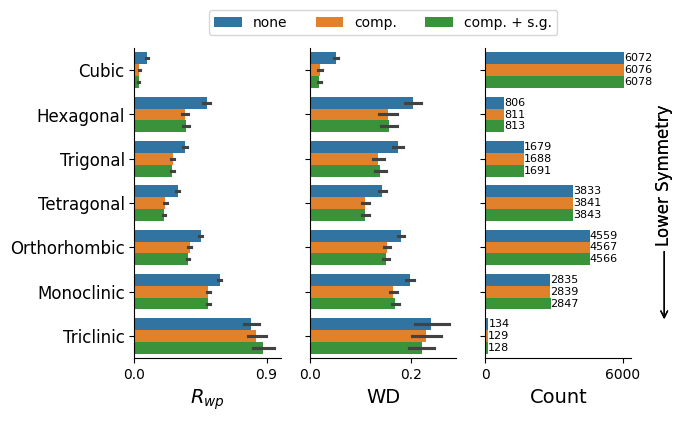

In [93]:
plot_data_visualization(
    plot_data,
    EVAL_DICT, 
    legend_title='',
    bbox_to_anchor=(0.53, 0.97),
    save_figure_path='baseline_crystal_systems_metrics.pdf',
    arrow_x = 0.9
)

In [103]:
# Constants and Configurations
EXPERIMENT_FOLDER = '../experiments/model__conditioned_mlp_augmentation__context_3076__robust/comparison_files_fullXRD__robust/'
DEBUG_MAX = None

EVAL_DICT = {
  '(0.00, 0.05)': 'deCIFer_chili_dedup_(Comp_N-0p00_B-0p05).pkl.gz',
  '(0.05, 0.10)': 'deCIFer_chili_dedup_(Comp_N-0p05_B-0p10).pkl.gz',
  '(0.10, 0.20)': 'deCIFer_chili_dedup_(Comp_N-0p10_B-0p20).pkl.gz',
}
data_dict = load_data(EVAL_DICT, EXPERIMENT_FOLDER)
plot_data = prepare_plot_data(data_dict, METRICS_TO_PLOT, EVAL_DICT)

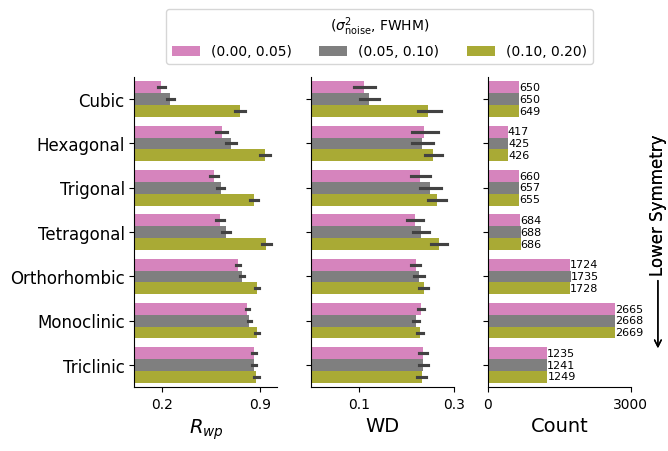

In [104]:
plot_data_visualization(
    plot_data,
    EVAL_DICT, 
    save_figure_path='chili_crystal_systems_metrics.pdf',
    color_list=[6,7,8],
    legend_title='($\sigma_{\mathrm{noise}}^2$, FWHM)',
    bbox_to_anchor=(0.53, 0.97),
    arrow_x = 0.9
    # title='CHILI-100K 20k subsample',
    # title_x = 0.45,
    # title_y = 1.1,
)

In [105]:
# Constants and Configurations
EXPERIMENT_FOLDER = '../experiments/model__conditioned_mlp_augmentation__context_3076__robust/comparison_files_fullXRD__robust/'
DEBUG_MAX = None

EVAL_DICT = {
  '(0.00, 0.05)': 'deCIFer_(Comp_N-0p00_B-0p05).pkl.gz',
  '(0.05, 0.10)': 'deCIFer_(Comp_N-0p05_B-0p10).pkl.gz',
  '(0.10, 0.20)': 'deCIFer_(Comp_N-0p10_B-0p20).pkl.gz',
}

data_dict = load_data(EVAL_DICT, EXPERIMENT_FOLDER)
plot_data = prepare_plot_data(data_dict, METRICS_TO_PLOT, EVAL_DICT)

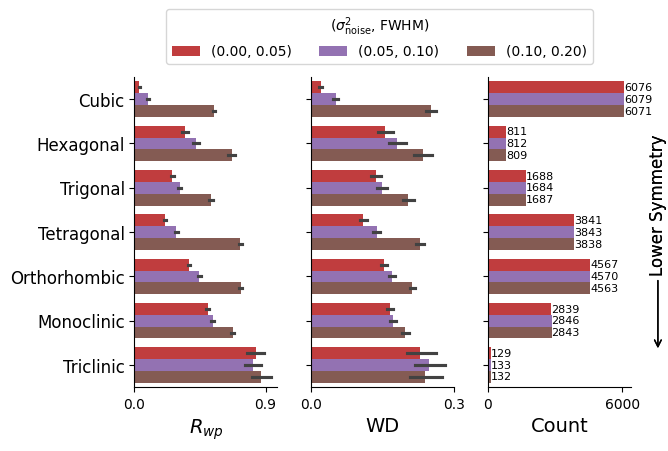

In [106]:
plot_data_visualization(
    plot_data,
    EVAL_DICT, 
    save_figure_path='robustness_crystal_systems_metrics.pdf',
    color_list=[3,4,5],
    legend_title='($\sigma_{\mathrm{noise}}^2$, FWHM)',
    bbox_to_anchor=(0.53, 0.97),
    arrow_x = 0.9
    # title='NOMA test set',
    # title_x = 0.45,
    # title_y = 1.1,
)